# PPP/PPP-RTK Demonstration


## Examples

This tutorial provides examples to show the basic features of CSSRlib for PPP-RTK, and PPP positioning using correction data from open PPP/PPP-RTK services. The following examples are included:

- PPP-RTK positioning (QZSS-CLAS)
- PPP positioning (BeiDou)
- PPP positioning (Galileo HAS)
- PPP positioning (IGS)
- PPP positioning (MADOCA-PPP)
- PPP positioning (PPP via SouthPAN)
- PPP positioning (JPL GDGPS via RTCM)

Note that despite the static setup
of the antenna, all data sets are processed assuming a non-stationary antenna. A motion model has not been used for the
receiver position. Instead, a sufficiently large amount of process noise has been added to the variance of the predicted position
states.

Click on the arrows in the left margin to open or close an example

## Example 1: PPP-RTK positioning (QZSS CLAS)

This section demonstrates PPP-RTK positioning using uncombined receiver observations and recorded QZSS
L6 binary messages.

First, load the required Python modules.

In [10]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from sys import stdout
from binascii import unhexlify

from cssrlib.cssrlib import cssr
from cssrlib.gnss import ecef2pos, Nav, time2gpst, timediff, time2str, time2doy
from cssrlib.gnss import rSigRnx, sys2str, epoch2time
from cssrlib.peph import atxdec, searchpcv
from cssrlib.ppprtk import ppprtkpos
from cssrlib.rinex import rnxdec

Define the RINEX observation, navigation, and antenna files, and starting epoch

In [21]:
# Start epoch, number of epochs
ep = [2025, 8, 21, 7, 0, 0] # year, month, day, hour, min, sec

time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))
let = chr(ord('a')+ep[3])
bdir = f'cssrlib-data/data/doy{ep[0]:04d}-{doy:03d}/'
navfile = bdir+f'{doy:03d}{let}_rnx.nav'
obsfile = bdir+f'{doy:03d}{let}_rnx.obs'

atxfile = 'cssrlib-data/data/antex/igs20.atx'

nav = Nav()
nav = dec.decode_nav(navfile, nav)

atx = atxdec()
atx.readpcv(atxfile)

For reference, specify the rover position.

In [22]:
xyz_ref = [-3962108.7007, 3381309.5532, 3668678.6648]
pos_ref = ecef2pos(xyz_ref)

QZSS CLAS correction messages are encoded in Compact SSR format. In this example, the recorded L6 data is used. Also load the grid position of QZSS CLAS as defined in IS-QZSS-L6
.

In [13]:
file_l6 = bdir + f'{doy:03d}{let}_qzsl6.txt'
prn_ref = 199  # QZSS PRN
l6_ch = 0  # 0:L6D, 1:L6E

griddef = 'cssrlib-data/data/clas_grid.def'
cs = cssr()
cs.monlevel = 1
time = epoch2time(ep)
cs.week = time2gpst(time)[0]
cs.read_griddef(griddef)

Specify signals to be processed. We choose L1C/A+L2P(Y) for GPS, E1+E5a for Galileo, L1C+L2C(L) for QZSS.

In [14]:
sigs = [rSigRnx("GC1C"), rSigRnx("GC2W"),
        rSigRnx("EC1C"), rSigRnx("EC5Q"),
        rSigRnx("JC1C"), rSigRnx("JC2L"),
        rSigRnx("GL1C"), rSigRnx("GL2W"),
        rSigRnx("EL1C"), rSigRnx("EL5Q"),
        rSigRnx("JL1C"), rSigRnx("JL2L"),
        rSigRnx("GS1C"), rSigRnx("GS2W"),
        rSigRnx("ES1C"), rSigRnx("ES5Q"),
        rSigRnx("JS1C"), rSigRnx("JS2L")]

rnx = rnxdec()
rnx.setSignals(sigs)

Initialize position and antenna PCO/PCVs

In [15]:
if rnx.decode_obsh(obsfile) >= 0:
    # Auto-substitute signals
    rnx.autoSubstituteSignals()

    # Initialize position
    ppprtk = ppprtkpos(nav, rnx.pos, 'test_ppprtk.log')

    # Set PCO/PCV information
    nav.rcv_ant = searchpcv(atx.pcvr, rnx.ant,  rnx.ts)
    # Get equipment information
    print(f"[Rover] Receiver: {dec.rcv} Antenna: {dec.ant}")

[Rover] Receiver: SEPT MOSAICX5        Antenna: JAVRINGANT_DM   JVDM


Print available signals and selected signals

In [16]:
print("Available signals")
for sys, sigs in rnx.sig_map.items():
    txt = "{:7s} {}".format(sys2str(sys),
            ' '.join([sig.str() for sig in sigs.values()]))
    print(txt)

print("\nSelected signals")
for sys, tmp in rnx.sig_tab.items():
    txt = "{:7s} ".format(sys2str(sys))
    for _, sigs in tmp.items():
        txt += "{} ".format(' '.join([sig.str() for sig in sigs]))
    print(txt)


Available signals
GPS     C1C L1C D1C S1C C2W L2W D2W S2W C2L L2L D2L S2L C5Q L5Q D5Q S5Q
GLONASS C1C L1C D1C S1C C2C L2C D2C S2C C2P L2P D2P S2P C3Q L3Q D3Q S3Q
GALILEO C1C L1C D1C S1C C5Q L5Q D5Q S5Q C7Q L7Q D7Q S7Q C8Q L8Q D8Q S8Q C6C L6C D6C S6C
BEIDOU  C1P L1P D1P S1P C2I L2I D2I S2I C5P L5P D5P S5P C6I L6I D6I S6I C7D L7D D7D S7D C7I L7I D7I S7I
QZSS    C1C L1C D1C S1C C1E L1E D1E S1E C1L L1L D1L S1L C2L L2L D2L S2L C5Q L5Q D5Q S5Q
IRNSS   C1P L1P D1P S1P C5A L5A D5A S5A

Selected signals
GPS     C1C C2W L1C L2W S1C S2W 
GALILEO C1C C5Q L1C L5Q S1C S5Q 
QZSS    C1C C2L L1C L2L S1C S2L 


Get grid location and open L6 file

In [17]:
pos = ecef2pos(rnx.pos)
inet = cs.find_grid_index(pos)

dtype = [('wn', 'int'), ('tow', 'int'), ('prn', 'int'),
          ('type', 'int'), ('len', 'int'), ('nav', 'S500')]
v = np.genfromtxt(file_l6, dtype=dtype)

Set runtime to 3 minutes and initialize variables

In [18]:
nep = 3*60  # 3 minutes, increase this for longer run

t = np.zeros(nep)
tc = np.zeros(nep)
enu = np.ones((nep, 3))*np.nan
sol = np.zeros((nep, 4))
dop = np.zeros((nep, 4))
smode = np.zeros(nep, dtype=int)

Run PPP-RTK positioning using `ppprtkpos()` for 3 minutes. QZSS L6 messages are encoded in sub-frames (5 second per sub-frame), for the simple implementation, the recorded data is decoded every 5 seconds.

In [20]:
# Skip epoch until start time
obs = rnx.decode_obs()
while time > obs.t and obs.t.time != 0:
    obs = rnx.decode_obs()

for ne in range(nep):
    week, tow = time2gpst(obs.t)

    vi = v[(v['tow'] == tow) & (v['type'] == l6_ch)
            & (v['prn'] == prn_ref)]
    if len(vi) > 0:
        cs.decode_l6msg(unhexlify(vi['nav'][0]), 0)
        if cs.fcnt == 5:  # end of sub-frame
            cs.decode_cssr(bytes(cs.buff), 0)

    if ne == 0:
        nav.t = deepcopy(obs.t)
        t0 = deepcopy(obs.t)
        t0.time = t0.time//30*30
        cs.time = obs.t
        nav.time_p = t0

    cstat = cs.chk_stat()
    if cstat:
        ppprtk.process(obs, cs=cs)

    t[ne] = timediff(nav.t, t0) / 60

    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = ecef2enu(pos_ref, sol-xyz_ref)
    smode[ne] = nav.smode

    # Log to standard output
    stdout.write('\r {} ENU {:7.3f} {:7.3f} {:7.3f}, 2D {:6.3f}, mode {:1d}'
                  .format(time2str(obs.t),
                          enu[ne, 0], enu[ne, 1], enu[ne, 2],
                          np.sqrt(enu[ne, 0]**2+enu[ne, 1]**2),
                          smode[ne]))

    # Get new epoch, exit after last epoch
    obs = rnx.decode_obs()
    if obs.t.time == 0:
        break

rnx.fobs.close()


 2025-08-21 07:03:01 ENU   0.017   0.002  -0.086, 2D  0.017, mode 4

Plot the solution position relative to the reference position.

A complete set of QZSS CLAS corrections is available every 30 seconds.  An ambiguity-fixed solution, as indicated by the green dots in the plot, is available just after the QZSS CLAS correction messages have been received. As expected,
the positioning errors are at centimeter level.

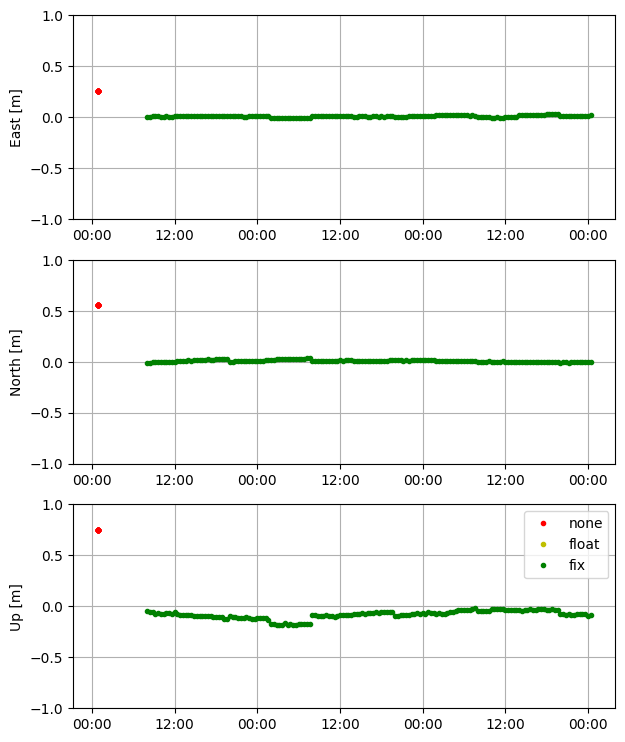

In [23]:
from cssrlib.plot import plot_enu

plot_enu(t, enu, smode)

Plot the horizontal errors.

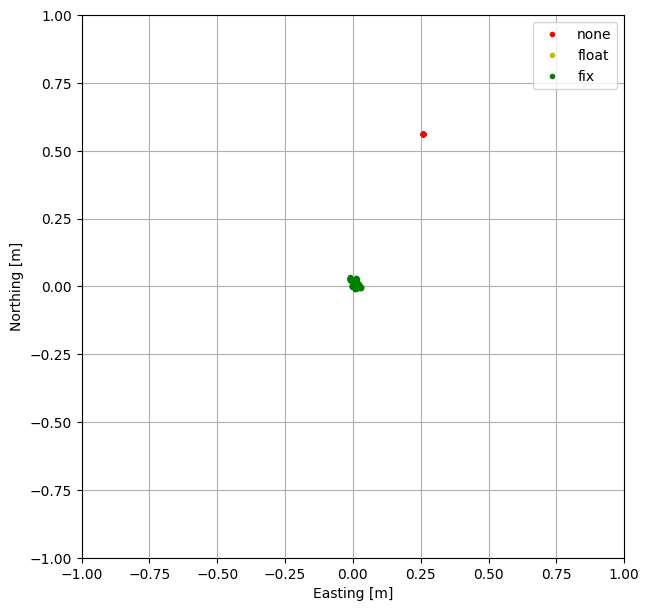

In [27]:
plot_enu(t, enu, smode, figtype=2)


## Example 2: PPP-AR positioning (IGS)

This section demonstrates PPP positioning using IGS offline products from the International GNSS Service (IGS) and a Septentrio PolaRx5 receiver. In this case, the orbit and clock offset information is obtained from
SP3 files and, optionally, Clock-RINEX files can be used. Pseudorange and carrier-phase observable specific biases (OSBs) are
loaded from Bias-SINEX files.

First, load the required Python modules.

In [33]:
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
from sys import stdout

from cssrlib.gnss import time2doy, time2str, timediff, epoch2time, ecef2enu, ecef2pos
from cssrlib.gnss import Nav, rSigRnx, sys2str
from cssrlib.peph import atxdec, searchpcv, peph, biasdec
from cssrlib.pppssr import pppos
from cssrlib.rinex import rnxdec

Define the input data and parameters for this example. For signals, we choosed L1C/A+L2P(Y) for GPS, E1+E5a for Galileo.

In [29]:
# Start epoch, number of epochs
ep = [2025, 8, 21, 7, 0, 0]

time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))
let = chr(ord('a')+ep[3])
bdir = f'cssrlib-data/data/doy{ep[0]:04d}-{doy:03d}/'
navfile = bdir+f'{doy:03d}{let}_rnx.nav'
obsfile = bdir+f'{doy:03d}{let}_rnx.obs'

ac = 'COD0OPSFIN'

orbfile = bdir+f'../igs/{ac}_{year:4d}{doy:03d}0000_01D_05M_ORB.SP3'
clkfile = bdir+f'../igs/{ac}_{year:4d}{doy:03d}0000_01D_30S_CLK.CLK'
bsxfile = bdir+f'../igs/{ac}_{year:4d}{doy:03d}0000_01D_01D_OSB.BIA'

# Set user reference position
xyz_ref = [-3962108.6836, 3381309.5672, 3668678.6720]
pos_ref = ecef2pos(xyz_ref)

# Define signals to be processed
sigs = [rSigRnx("GC1C"), rSigRnx("GC2W"),
        rSigRnx("GL1C"), rSigRnx("GL2W"),
        rSigRnx("GS1C"), rSigRnx("GS2W"),
        rSigRnx("EC1C"), rSigRnx("EC5Q"),
        rSigRnx("EL1C"), rSigRnx("EL5Q"),
        rSigRnx("ES1C"), rSigRnx("ES5Q")]

atxfile = bdir+'../antex/I20.ATX'

Load and parse the input data

In [30]:
rnx = rnxdec()
rnx.setSignals(sigs)

nav = Nav()
orb = peph()

nav.pmode = 0 # Positioning mode: 0:static, 1:kinematic

# Decode RINEX NAV data
nav = rnx.decode_nav(navfile, nav)

# Load precise orbits and clock offsets
nav = orb.parse_sp3(orbfile, nav)
nav = rnx.decode_clk(clkfile, nav)

# Load code and phase biases from Bias-SINEX
bsx = biasdec()
bsx.parse(bsxfile)

# Load ANTEX data for satellites and stations
atx = atxdec()
atx.readpcv(atxfile)

nav.monlevel = 0  # Logging level

# Load RINEX OBS file header
if rnx.decode_obsh(obsfile) >= 0:

    # Auto-substitute signals
    rnx.autoSubstituteSignals()

    # Initialize position
    ppp = pppos(nav, rnx.pos, 'test_pppigs.log')
    nav.ephopt = 4  # IGS
    nav.armode = 3  # 1: continuous, 3: fix-and-hold
    nav.parmode = 1 # 1: normal, 2: partial ambiguity resolution

    # change default settings
    nav.elmin = np.deg2rad(10.0)  # min sat elevation
    nav.thresar = 2.0            # ambiguity resolution threshold

    # Set PCO/PCV information
    nav.sat_ant = atx.pcvs
    nav.rcv_ant = searchpcv(atx.pcvr, rnx.ant,  rnx.ts)

Print the available and selected satellite signals

In [34]:
print("Available signals")
for sys, sigs in rnx.sig_map.items():
  txt = "{:7s} {}".format(sys2str(sys),
        ' '.join([sig.str() for sig in sigs.values()]))
  print(txt)

print("\nSelected signals")
for sys, tmp in rnx.sig_tab.items():
  txt = "{:7s} ".format(sys2str(sys))
  for _, sigs in tmp.items():
    txt += "{} ".format(' '.join([sig.str() for sig in sigs]))
  print(txt)

Available signals
GPS     C1C L1C D1C S1C C2W L2W D2W S2W C2L L2L D2L S2L C5Q L5Q D5Q S5Q
GLONASS C1C L1C D1C S1C C2C L2C D2C S2C C2P L2P D2P S2P C3Q L3Q D3Q S3Q
GALILEO C1C L1C D1C S1C C5Q L5Q D5Q S5Q C7Q L7Q D7Q S7Q C8Q L8Q D8Q S8Q C6C L6C D6C S6C
BEIDOU  C1P L1P D1P S1P C2I L2I D2I S2I C5P L5P D5P S5P C6I L6I D6I S6I C7D L7D D7D S7D C7I L7I D7I S7I
QZSS    C1C L1C D1C S1C C1E L1E D1E S1E C1L L1L D1L S1L C2L L2L D2L S2L C5Q L5Q D5Q S5Q
IRNSS   C1P L1P D1P S1P C5A L5A D5A S5A

Selected signals
GPS     C1C C2W L1C L2W S1C S2W 
GALILEO C1C C5Q L1C L5Q S1C S5Q 


Run solution for 15 minutes (ok to abort before finished)

In [35]:
# increase to run longer, set to 10 minutes to see ambiguity resolution
nep = 15 * 60  # 15 minutes

# Intialize data structures for results
t = np.zeros(nep)
tc = np.zeros(nep)
enu = np.ones((nep, 3))*np.nan
sol = np.zeros((nep, 4))
dop = np.zeros((nep, 4))
ztd = np.zeros((nep, 1))
smode = np.zeros(nep, dtype=int)

# Skip epochs until start time
obs = rnx.decode_obs()
while time > obs.t and obs.t.time != 0:
    obs = rnx.decode_obs()

# Loop over number of epoch from file start
for ne in range(nep):

    # Set initial epoch
    if ne == 0:
        nav.t = deepcopy(obs.t)
        t0 = deepcopy(obs.t)

    # Call PPP module with IGS products
    ppp.process(obs, orb=orb, bsx=bsx)

    # Save output
    t[ne] = timediff(nav.t, t0) / 86400.0

    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = ecef2enu(pos_ref, sol-xyz_ref)

    ztd[ne] = nav.xa[ppp.IT(nav.na)] if nav.smode == 4 else nav.x[ppp.IT(nav.na)]
    smode[ne] = nav.smode

    # Log to standard output
    stdout.write('\r {} ENU {:7.3f} {:7.3f} {:7.3f}, 2D {:6.3f}, mode {:1d}'
                 .format(time2str(obs.t),
                         enu[ne, 0], enu[ne, 1], enu[ne, 2],
                         np.sqrt(enu[ne, 0]**2+enu[ne, 1]**2),
                         smode[ne]))

    # Get new epoch, exit after last epoch
    obs = rnx.decode_obs()
    if obs.t.time == 0:
        break

rnx.fobs.close()


 2025-08-21 07:15:01 ENU  -0.197   0.098  -0.267, 2D  0.220, mode 5

Plot results.

The default run length is set to 15 minutes to keep the tutorial moving.

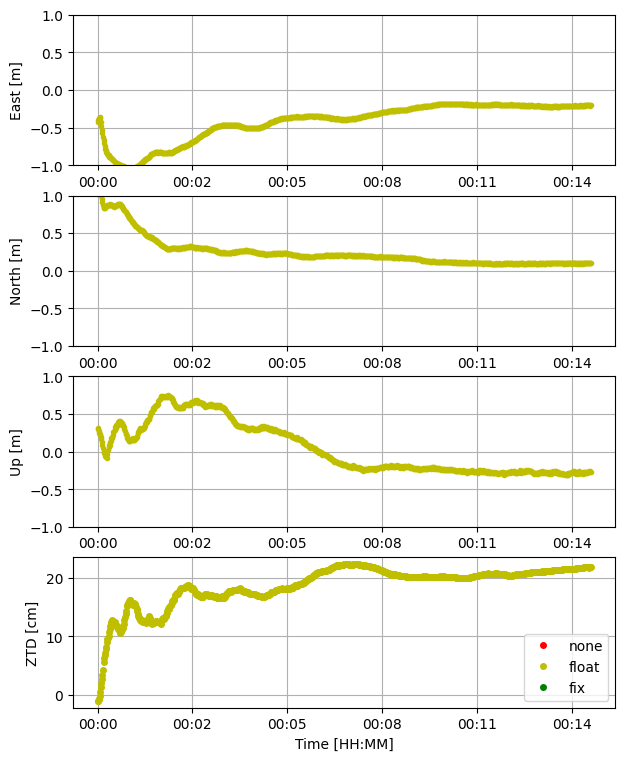

In [42]:
from cssrlib.plot import plot_enu

plot_enu(t, enu, smode, ztd)

## Example 3: PPP positioning (BDS PPP)

This section demonstrates PPP-RTK positioning using BDS B1C and B2a pilot observations for BDS-3 B2b PPP and GPS L1 C/A and L2 P(Y) with a Septentrio mosaic-X5 receiver.

First, load the required Python modules.

In [49]:
from binascii import unhexlify
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
from sys import stdout

from cssrlib.gnss import ecef2pos, ecef2enu, Nav, rSigRnx, sys2str
from cssrlib.gnss import time2gpst, time2doy, time2str, timediff, epoch2time
from cssrlib.peph import atxdec, searchpcv, peph
from cssrlib.cssr_bds import cssr_bds
from cssrlib.pppssr import pppos
from cssrlib.rinex import rnxdec

Define the input data and parameters for this example. For signals, we choose L1C/A+L2P(Y) for GPS, B1C(P)+B2a(P) for BDS.

In [51]:
ep = [2025, 8, 21, 7, 0, 0] # start epoch

time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))

let = chr(ord('a')+ep[3])
bdir = f'cssrlib-data/data/doy{ep[0]:04d}-{doy:03d}/'
navfile = bdir+f'{doy:03d}{let}_rnx.nav'
obsfile = bdir+f'{doy:03d}{let}_rnx.obs'
atxfile = bdir+'../antex/igs20.atx'

file_bds = bdir+f'{doy:03d}{let}_bdsb2b.txt'
prn_ref = 59  # satellite PRN to receive BDS PPP collection

dtype = [('wn', 'int'), ('tow', 'int'), ('prn', 'int'),
         ('type', 'int'), ('len', 'int'), ('nav', 'S124')]

xyz_ref = [-3962108.6836, 3381309.5672, 3668678.6720]
pos_ref = ecef2pos(xyz_ref)

# Define signals to be processed
sigs = [rSigRnx("GC1C"), rSigRnx("GC2W"),
        rSigRnx("GL1C"), rSigRnx("GL2W"),
        rSigRnx("GS1C"), rSigRnx("GS2W"),
        rSigRnx("CC1P"), rSigRnx("CC5P"),
        rSigRnx("CL1P"), rSigRnx("CL5P"),
        rSigRnx("CS1P"), rSigRnx("CS5P")]

time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))

Load and parse the input data

In [52]:
rnx = rnxdec()
rnx.setSignals(sigs)

nav = Nav()
orb = peph()

nav.pmode = 0 # Positioning mode: 0:static, 1:kinematic

# Decode RINEX NAV data
nav = rnx.decode_nav(navfile, nav)

# Load PPP corrections
v = np.genfromtxt(file_bds, dtype=dtype)

cs = cssr_bds()
cs.monlevel = 0

# Load ANTEX data for satellites and stations
atx = atxdec()
atx.readpcv(atxfile)

nav.monlevel = 0  # Logging level

# Load RINEX OBS file header
if rnx.decode_obsh(obsfile) >= 0:

    # Auto-substitute signals
    rnx.autoSubstituteSignals()

    # Initialize position
    ppp = pppos(nav, rnx.pos, 'test_pppbds.log')

    # Set PCO/PCV information
    nav.sat_ant = atx.pcvs
    nav.rcv_ant = searchpcv(atx.pcvr, rnx.ant,  rnx.ts)

Print the available and selected satellite signals

In [46]:
print("Available signals")
for sys, sigs in rnx.sig_map.items():
  txt = "{:7s} {}".format(sys2str(sys),
        ' '.join([sig.str() for sig in sigs.values()]))
  print(txt)

print("\nSelected signals")
for sys, tmp in rnx.sig_tab.items():
  txt = "{:7s} ".format(sys2str(sys))
  for _, sigs in tmp.items():
    txt += "{} ".format(' '.join([sig.str() for sig in sigs]))
  print(txt)

Available signals
GPS     C1C L1C D1C S1C C2W L2W D2W S2W C2L L2L D2L S2L C5Q L5Q D5Q S5Q
GLONASS C1C L1C D1C S1C C2C L2C D2C S2C C2P L2P D2P S2P C3Q L3Q D3Q S3Q
GALILEO C1C L1C D1C S1C C5Q L5Q D5Q S5Q C7Q L7Q D7Q S7Q C8Q L8Q D8Q S8Q C6C L6C D6C S6C
BEIDOU  C1P L1P D1P S1P C2I L2I D2I S2I C5P L5P D5P S5P C6I L6I D6I S6I C7D L7D D7D S7D C7I L7I D7I S7I
QZSS    C1C L1C D1C S1C C1E L1E D1E S1E C1L L1L D1L S1L C2L L2L D2L S2L C5Q L5Q D5Q S5Q
IRNSS   C1P L1P D1P S1P C5A L5A D5A S5A

Selected signals
GPS     C1C C2W L1C L2W S1C S2W 
BEIDOU  C1P C5P L1P L5P S1P S5P 


Process data for 15 minutes (ok to abort before finished)

In [53]:
nep = 15 * 60  # increase this to run longer

# Intialize data structures for results
t = np.zeros(nep)
tc = np.zeros(nep)
enu = np.ones((nep, 3))*np.nan
sol = np.zeros((nep, 4))
dop = np.zeros((nep, 4))
ztd = np.zeros((nep, 1))
smode = np.zeros(nep, dtype=int)

# Skip epochs until start time
obs = rnx.decode_obs()
while time > obs.t and obs.t.time != 0:
    obs = rnx.decode_obs()

# Loop over number of epoch from file start
for ne in range(nep):
    week, tow = time2gpst(obs.t)
    cs.week = week
    cs.tow0 = tow // 86400 * 86400

    # Set intial epoch
    if ne == 0:
        nav.t = deepcopy(obs.t)
        t0 = deepcopy(obs.t)
        t0.time = t0.time // 30 * 30
        nav.time_p = t0

    vi = v[(v['tow'] == tow) & (v['prn'] == prn_ref)]
    if len(vi) > 0:
        buff = unhexlify(vi['nav'][0])
        cs.decode_cssr(buff, 0)

    # Call PPP module with BDS-PPP corrections
    if (cs.lc[0].cstat & 0xf) == 0xf:
        ppp.process(obs, cs=cs)

    # Save output
    t[ne] = timediff(nav.t, t0) / 86400.0

    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = ecef2enu(pos_ref, sol-xyz_ref)

    ztd[ne] = nav.xa[ppp.IT(nav.na)] if nav.smode == 4 else nav.x[ppp.IT(nav.na)]
    smode[ne] = nav.smode

    # Log to standard output
    stdout.write('\r {} ENU {:7.3f} {:7.3f} {:7.3f}, 2D {:6.3f}, mode {:1d}'
                 .format(time2str(obs.t),
                         enu[ne, 0], enu[ne, 1], enu[ne, 2],
                         np.sqrt(enu[ne, 0]**2+enu[ne, 1]**2),
                         smode[ne]))

    # Get new epoch, exit after last epoch
    obs = rnx.decode_obs()
    if obs.t.time == 0:
        break

rnx.fobs.close()

 2025-08-21 07:00:27 ENU   0.280   0.554   0.748, 2D  0.621, mode 0 too few satellites < 6: nsat=3
 2025-08-21 07:15:00 ENU  -0.127  -0.045   0.302, 2D  0.135, mode 5

Plot results

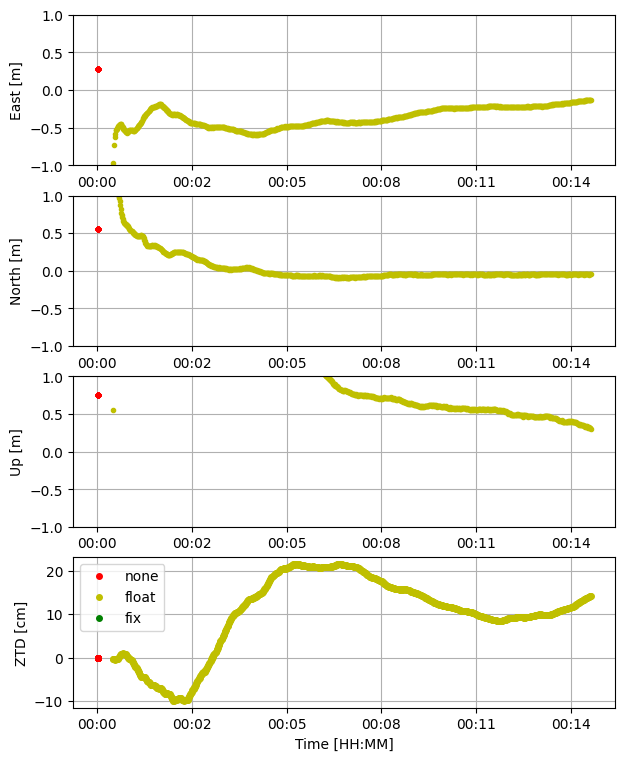

In [ ]:
from cssrlib.plot import plot_enu

plot_enu(t, enu, smode, ztd)


## Example 4: PPP positioning (Galileo HAS)

This section demonstrates PPP positioning using Galileo HAS corrections with a Septentrio mosaic-X5 receiver.

First, load the required Python modules.

In [61]:
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
from binascii import unhexlify
import bitstruct as bs
from sys import stdout

from cssrlib.gnss import ecef2pos, ecef2enu, Nav, rSigRnx, sys2str
from cssrlib.gnss import time2gpst, time2doy, time2str, timediff, epoch2time
from cssrlib.peph import atxdec, searchpcv
from cssrlib.cssr_has import cssr_has, cnav_msg
from cssrlib.pppssr import pppos
from cssrlib.rinex import rnxdec

Define the input data and parameters for this example

In [63]:
# Start epoch and number of epochs
ep = [2025, 8, 21, 7, 0, 0] # start epoch

time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))

let = chr(ord('a')+ep[3])
bdir = f'cssrlib-data/data/doy{ep[0]:04d}-{doy:03d}/'
navfile = bdir+f'{doy:03d}{let}_rnx.nav'
obsfile = bdir+f'{doy:03d}{let}_rnx.obs'
atxfile = bdir+'../antex/igs20.atx'

# Specify Galile HAS corrections files
file_has = bdir+f'{doy:03d}{let}_gale6.txt'

dtype = [('wn', 'int'), ('tow', 'int'), ('prn', 'int'),
         ('type', 'int'), ('len', 'int'), ('nav', 'S124')]

# Set user reference position
xyz_ref = [-3962108.6836, 3381309.5672, 3668678.6720]
pos_ref = ecef2pos(xyz_ref)

# Define signals to be processed
sigs = [rSigRnx("GC1C"), rSigRnx("GC2L"),
        rSigRnx("GL1C"), rSigRnx("GL2L"),
        rSigRnx("GS1C"), rSigRnx("GS2L"),
        rSigRnx("EC1C"), rSigRnx("EC5Q"),
        rSigRnx("EL1C"), rSigRnx("EL5Q"),
        rSigRnx("ES1C"), rSigRnx("ES5Q")]

For decoding Galileo CNAV pages, Galileo CNAV message parser is defined. And, a table for Reed-Solomon decoding has loaded.

In [64]:
# Table for Reed-Solomon decoding
file_gm = bdir+"../../samples/Galileo-HAS-SIS-ICD_1.0_Annex_B_Reed_Solomon_Generator_Matrix.txt"
# Galileo CNAV message parser
cnav = cnav_msg()
cnav.load_gmat(file_gm)

Load and parse the input data

In [65]:
rnx = rnxdec()
rnx.setSignals(sigs)

nav = Nav()
nav.pmode = 0 # Positioning mode: 0:static, 1:kinematic

# Decode RINEX NAV data
nav = rnx.decode_nav(navfile, nav)

# Load PPP corrections
v = np.genfromtxt(file_has, dtype=dtype)
gMat = np.genfromtxt(file_gm, dtype="u1", delimiter=",")

# Load ANTEX data for satellites and stations
atx = atxdec()
atx.readpcv(atxfile)

cs = cssr_has()
# cs.monlevel = 2
nav.monlevel = 0  # Logging level

# Load RINEX OBS file header
if rnx.decode_obsh(obsfile) >= 0:

    # Auto-substitute signals
    rnx.autoSubstituteSignals()

    # Initialize position
    ppp = pppos(nav, rnx.pos, 'test_ppphas.log')

    # Modify default config parameters
    nav.elmin = np.deg2rad(5.0)  # min sat el

    # Set PCO/PCV information
    nav.sat_ant = atx.pcvs
    nav.rcv_ant = searchpcv(atx.pcvr, rnx.ant,  rnx.ts)

Print the available satellite and selected signals. We choose L1C/A+L2P(Y) for GPS, E1+E5b for Galileo.

In [59]:
print("Available signals")
for sys, sigs in rnx.sig_map.items():
  txt = "{:7s} {}".format(sys2str(sys),
        ' '.join([sig.str() for sig in sigs.values()]))
  print(txt)

print("\nSelected signals")
for sys, tmp in rnx.sig_tab.items():
  txt = "{:7s} ".format(sys2str(sys))
  for _, sigs in tmp.items():
    txt += "{} ".format(' '.join([sig.str() for sig in sigs]))
  print(txt)

Available signals
GPS     C1C L1C D1C S1C C2W L2W D2W S2W C2L L2L D2L S2L C5Q L5Q D5Q S5Q
GLONASS C1C L1C D1C S1C C2C L2C D2C S2C C2P L2P D2P S2P C3Q L3Q D3Q S3Q
GALILEO C1C L1C D1C S1C C5Q L5Q D5Q S5Q C7Q L7Q D7Q S7Q C8Q L8Q D8Q S8Q C6C L6C D6C S6C
BEIDOU  C1P L1P D1P S1P C2I L2I D2I S2I C5P L5P D5P S5P C6I L6I D6I S6I C7D L7D D7D S7D C7I L7I D7I S7I
QZSS    C1C L1C D1C S1C C1E L1E D1E S1E C1L L1L D1L S1L C2L L2L D2L S2L C5Q L5Q D5Q S5Q
IRNSS   C1P L1P D1P S1P C5A L5A D5A S5A

Selected signals
GPS     C1C C2L L1C L2L S1C S2L 
GALILEO C1C C5Q L1C L5Q S1C S5Q 


Process data for 15 minutes (ok to abort before finished)

In [66]:
nep = 15 * 60  # increase this to run longer

# Intialize data structures for results
t = np.zeros(nep)
enu = np.ones((nep, 3))*np.nan
sol = np.zeros((nep, 4))
ztd = np.zeros((nep, 1))
smode = np.zeros(nep, dtype=int)
nsat = np.zeros((nep, 3), dtype=int)

# Skip epochs until start time
obs = rnx.decode_obs()
while time > obs.t and obs.t.time != 0:
    obs = rnx.decode_obs()

# Loop over number of epoch from file start
for ne in range(nep):
    week, tow = time2gpst(obs.t)
    cs.week = week
    cs.tow0 = tow // 3600 * 3600

    # Set initial epoch
    if ne == 0:
        nav.t = deepcopy(obs.t)
        t0 = deepcopy(obs.t)
        t0.time = t0.time // 30 * 30
        nav.time_p = t0

    vi = v[v['tow'] == tow]

    HASmsg = cnav.decode_cnav(tow, vi)  # decode CNAV pages
    if HASmsg is not None:
        cs.msgtype = cnav.msgtype
        cs.decode_cssr(HASmsg)  # decode HAS messages

    # Call PPP module with HAS corrections
    if (cs.lc[0].cstat & 0xf) == 0xf:
        ppp.process(obs, cs=cs)

    # Save output
    t[ne] = timediff(nav.t, t0) / 86400.0

    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = ecef2enu(pos_ref, sol-xyz_ref)

    ztd[ne] = nav.xa[ppp.IT(nav.na)] if nav.smode == 4 else nav.x[ppp.IT(nav.na)]
    smode[ne] = nav.smode
    nsat[ne, :] = nav.nsat

    nav.fout.write("{} {:14.4f} {:14.4f} {:14.4f} "
                    "ENU {:7.3f} {:7.3f} {:7.3f}, 2D {:6.3f}, mode {:1d}\n"
                    .format(time2str(obs.t),
                            sol[0], sol[1], sol[2],
                            enu[ne, 0], enu[ne, 1], enu[ne, 2],
                            np.sqrt(enu[ne, 0]**2+enu[ne, 1]**2),
                            smode[ne]))

    stdout.write('\r {} ENU {:7.3f} {:7.3f} {:7.3f}, 2D {:6.3f}, mode {:1d} nsat {:2d}/{:2d}/{:2d}'
                 .format(time2str(obs.t),
                         enu[ne, 0], enu[ne, 1], enu[ne, 2],
                         np.sqrt(enu[ne, 0]**2+enu[ne, 1]**2),
                         smode[ne],
                         nsat[ne, 0], nsat[ne, 1], nsat[ne, 2]))

    # Get new epoch, exit after last epoch
    obs = rnx.decode_obs()
    if obs.t.time == 0:
        break

stdout.write('\n')
rnx.fobs.close()


 2025-08-21 07:15:00 ENU   0.035   0.224  -0.582, 2D  0.226, mode 5 nsat 19/16/16


Plot results

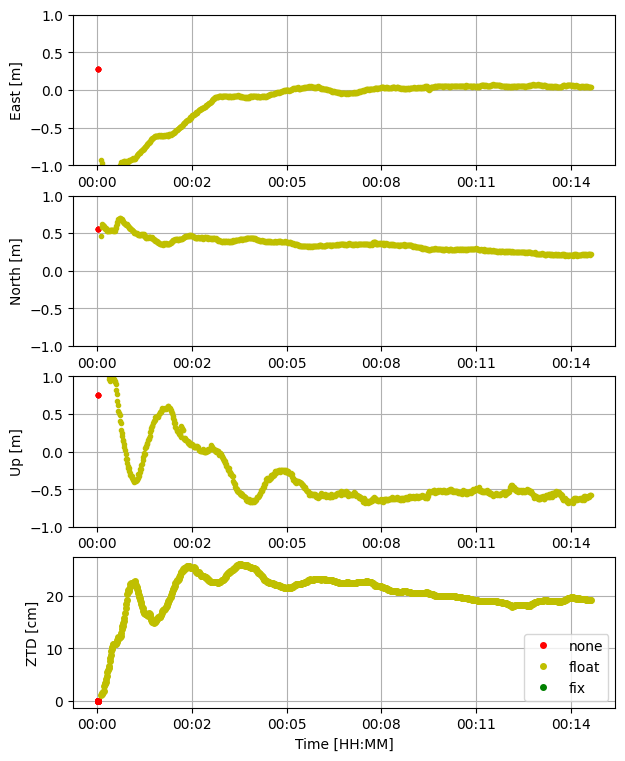

In [67]:
from cssrlib.plot import plot_enu

plot_enu(t, enu, smode, ztd)


## Example 5: PPP positioning (MADOCA-PPP)

This section demonstrates PPP positioning using QZSS MADOCA-PPP corrections from Javad DELTA-3S receiver and obserbations with a Septentrio mosaic-X5 receiver.

First, load the required Python modules.

In [68]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from binascii import unhexlify
from sys import stdout

from cssrlib.gnss import ecef2pos, ecef2enu, Nav, rSigRnx, sys2str
from cssrlib.gnss import time2gpst, time2doy, time2str, timediff, epoch2time
from cssrlib.peph import atxdec, searchpcv
from cssrlib.cssr_mdc import cssr_mdc
from cssrlib.pppssr import pppos
from cssrlib.rinex import rnxdec

Define the input data and parameters for this example

In [69]:
# Start epoch and number of epochs
ep = [2025, 8, 21, 7, 0, 0]

time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))

let = chr(ord('a')+ep[3])
bdir = f'cssrlib-data/data/doy{ep[0]:04d}-{doy:03d}/'
navfile = bdir+f'{doy:03d}{let}_rnx.nav'
obsfile = bdir+f'{doy:03d}{let}_rnx.obs'
atxfile = bdir+'../antex/igs20.atx'

# Specify L6 corrections files
file_l6 = bdir+f'{doy:03d}{let}_qzsl6.txt'
prn_ref = 199  # QZSS PRN
l6_ch = 1  # 0:L6D, 1:L6E
dtype = [('wn', 'int'), ('tow', 'int'), ('prn', 'int'),
         ('type', 'int'), ('len', 'int'), ('nav', 'S500')]

# Set user reference position
xyz_ref = [-3962108.6836, 3381309.5672, 3668678.6720]
pos_ref = ecef2pos(xyz_ref)

# Define signals to be processed
sigs = [rSigRnx("GC1C"), rSigRnx("GC2W"),
        rSigRnx("GL1C"), rSigRnx("GL2W"),
        rSigRnx("GS1C"), rSigRnx("GS2W"),
        rSigRnx("EC1C"), rSigRnx("EC5Q"),
        rSigRnx("EL1C"), rSigRnx("EL5Q"),
        rSigRnx("ES1C"), rSigRnx("ES5Q"),
        rSigRnx("JC1C"), rSigRnx("JC2L"),
        rSigRnx("JL1C"), rSigRnx("JL2L"),
        rSigRnx("JS1C"), rSigRnx("JS2L")]


Load and parse the input data

In [70]:
rnx = rnxdec()
rnx.setSignals(sigs)

nav = Nav()
nav.pmode = 0 # Positioning mode: 0:static, 1:kinematic

# Decode RINEX NAV data
nav = rnx.decode_nav(navfile, nav)

# Load PPP corrections
v = np.genfromtxt(file_l6, dtype=dtype)

cs = cssr_mdc('madoca_cssr.log')
cs.monlevel = 0

# Load ANTEX data for satellites and stations
atx = atxdec()
atx.readpcv(atxfile)

nav.monlevel = 0  # Logging level

# Load RINEX OBS file header
if rnx.decode_obsh(obsfile) >= 0:

    # Auto-substitute signals
    rnx.autoSubstituteSignals()

    # Initialize position
    rr = rnx.pos
    pos = ecef2pos(rr)
    ppp = pppos(nav, rnx.pos, 'test_pppmdc.log')
    nav.elmin = np.deg2rad(5.0)
    nav.glo_ch = rnx.glo_ch

    # Set PCO/PCV information
    nav.sat_ant = atx.pcvs
    nav.rcv_ant = searchpcv(atx.pcvr, rnx.ant,  rnx.ts)

Print the available satellite signals

In [71]:
print("Available signals")
for sys, sigs in rnx.sig_map.items():
  txt = "{:7s} {}".format(sys2str(sys),
        ' '.join([sig.str() for sig in sigs.values()]))
  print(txt)

print("\nSelected signals")
for sys, tmp in rnx.sig_tab.items():
  txt = "{:7s} ".format(sys2str(sys))
  for _, sigs in tmp.items():
    txt += "{} ".format(' '.join([sig.str() for sig in sigs]))
  print(txt)

Available signals
GPS     C1C L1C D1C S1C C2W L2W D2W S2W C2L L2L D2L S2L C5Q L5Q D5Q S5Q
GLONASS C1C L1C D1C S1C C2C L2C D2C S2C C2P L2P D2P S2P C3Q L3Q D3Q S3Q
GALILEO C1C L1C D1C S1C C5Q L5Q D5Q S5Q C7Q L7Q D7Q S7Q C8Q L8Q D8Q S8Q C6C L6C D6C S6C
BEIDOU  C1P L1P D1P S1P C2I L2I D2I S2I C5P L5P D5P S5P C6I L6I D6I S6I C7D L7D D7D S7D C7I L7I D7I S7I
QZSS    C1C L1C D1C S1C C1E L1E D1E S1E C1L L1L D1L S1L C2L L2L D2L S2L C5Q L5Q D5Q S5Q
IRNSS   C1P L1P D1P S1P C5A L5A D5A S5A

Selected signals
GPS     C1C C2W L1C L2W S1C S2W 
GALILEO C1C C5Q L1C L5Q S1C S5Q 
QZSS    C1C C2L L1C L2L S1C S2L 


Process data for 15 minutes (ok to abort before finished)

In [72]:
nep = 15 * 60  # increase this to run longer

# Intialize data structures for results
t = np.zeros(nep)
enu = np.ones((nep, 3))*np.nan
sol = np.zeros((nep, 4))
ztd = np.zeros((nep, 1))
smode = np.zeros(nep, dtype=int)

# Skip epochs until start time
obs = rnx.decode_obs()
while time > obs.t and obs.t.time != 0:
    obs = rnx.decode_obs()

# Loop over number of epoch from file start
for ne in range(nep):
    week, tow = time2gpst(obs.t)
    cs.week = week
    cs.tow0 = tow // 3600*3600

    # Set initial epoch
    if ne == 0:
        nav.t = deepcopy(obs.t)
        t0 = deepcopy(obs.t)
        t0.time = t0.time//30*30
        nav.time_p = t0

    vi = v[(v['tow'] == tow) & (v['type'] == l6_ch)
           & (v['prn'] == prn_ref)]
    if len(vi) > 0:
      msg = unhexlify(vi['nav'][0])
      cs.decode_l6msg(msg, 0)
      if cs.fcnt == 5:  # end of sub-frame
          cs.decode_cssr(cs.buff, 0)

    # Call PPP module
    if (cs.lc[0].cstat & 0xf) == 0xf:
        ppp.process(obs, cs=cs)

    # Save output
    t[ne] = timediff(nav.t, t0) / 86400.0
    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = ecef2enu(pos_ref, sol-xyz_ref)
    ztd[ne] = nav.xa[ppp.IT(nav.na)] if nav.smode == 4 else nav.x[ppp.IT(nav.na)]
    smode[ne] = nav.smode

    # Log to standard output
    stdout.write('\r {} ENU {:7.3f} {:7.3f} {:7.3f}, 2D {:6.3f}, mode {:1d}'
                 .format(time2str(obs.t),
                         enu[ne, 0], enu[ne, 1], enu[ne, 2],
                         np.sqrt(enu[ne, 0]**2+enu[ne, 1]**2),
                         smode[ne]))

    # Get new epoch, exit after last epoch
    obs = rnx.decode_obs()
    if obs.t.time == 0:
        break

 2025-08-21 07:15:00 ENU  -0.191   0.079  -0.037, 2D  0.207, mode 5

Plot results

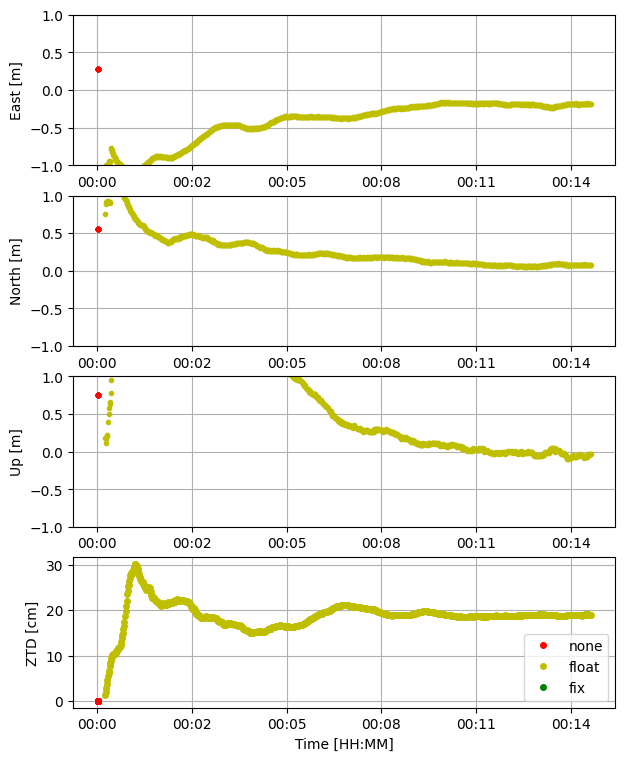

In [73]:
from cssrlib.plot import plot_enu

plot_enu(t, enu, smode, ztd)

## Example 6: PPP positioning (PPP via SouthPAN)

This section demonstrates PPP positioning using PPP via SouthPAN (PVS) corrections with a Septentrio mosaic-X5 receiver.

In [74]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from binascii import unhexlify
from sys import stdout

from cssrlib.gnss import ecef2pos, ecef2enu, Nav, rSigRnx, sys2str
from cssrlib.gnss import time2gpst, time2doy, time2str, timediff, epoch2time
from cssrlib.peph import atxdec, searchpcv
from cssrlib.cssr_pvs import cssr_pvs
from cssrlib.pppssr import pppos
from cssrlib.rinex import rnxdec

PVS correction data can be obtained from L5 SBAS correction from PRN 122. 

In [75]:
# Start epoch and number of epochs
ep = [2025, 8, 21, 7, 0, 0]

time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))

let = chr(ord('a')+ep[3])
bdir = f'cssrlib-data/data/doy{ep[0]:04d}-{doy:03d}/'
navfile = bdir+f'{doy:03d}{let}_rnx.nav'
obsfile = bdir+f'{doy:03d}{let}_rnx.obs'
atxfile = bdir+'../antex/igs20.atx'

# Specify SBAS corrections files
file_sbas = bdir+f'{doy:03d}{let}_sbas.txt'
prn_ref = 122  # satellite PRN for PRN122
sbas_type = 1  # L1: 0, L5: 1

dtype = [('wn', 'int'), ('tow', 'float'), ('prn', 'int'),
         ('type', 'int'), ('marker', 'S2'), ('nav', 'S124')]

# Set user reference position
xyz_ref = [-3962108.6836, 3381309.5672, 3668678.6720]
pos_ref = ecef2pos(xyz_ref)

# Define signals to be processed
sigs = [rSigRnx("GC1C"), rSigRnx("GC5Q"),
        rSigRnx("GL1C"), rSigRnx("GL5Q"),
        rSigRnx("GS1C"), rSigRnx("GS5Q"),
        rSigRnx("EC1C"), rSigRnx("EC5Q"),
        rSigRnx("EL1C"), rSigRnx("EL5Q"),
        rSigRnx("ES1C"), rSigRnx("ES5Q")]


Antenna PCO/PCV correction parameters are loaded. 

In [76]:
rnx = rnxdec()
rnx.setSignals(sigs)

nav = Nav()
nav.pmode = 0 # Positioning mode: 0:static, 1:kinematic

# Decode RINEX NAV data
nav = rnx.decode_nav(navfile, nav)

# Load PPP corrections
v = np.genfromtxt(file_sbas, dtype=dtype)

cs = cssr_pvs()
cs.monlevel = 0

# Load ANTEX data for satellites and stations
atx = atxdec()
atx.readpcv(atxfile)

nav.monlevel = 0  # Logging level

# Load RINEX OBS file header
if rnx.decode_obsh(obsfile) >= 0:

    # Auto-substitute signals
    rnx.autoSubstituteSignals()

    # Initialize position
    rr = rnx.pos
    pos = ecef2pos(rr)
    ppp = pppos(nav, rnx.pos, 'test_ppppvs.log')
    nav.elmin = np.deg2rad(5.0)
    nav.glo_ch = rnx.glo_ch

    # Set PCO/PCV information
    nav.sat_ant = atx.pcvs
    nav.rcv_ant = searchpcv(atx.pcvr, rnx.ant,  rnx.ts)

For signals, L1C/A+L5 for GPS, E1+E5a for Galileo are used.

In [77]:
print("Available signals")
for sys, sigs in rnx.sig_map.items():
  txt = "{:7s} {}".format(sys2str(sys),
        ' '.join([sig.str() for sig in sigs.values()]))
  print(txt)

print("\nSelected signals")
for sys, tmp in rnx.sig_tab.items():
  txt = "{:7s} ".format(sys2str(sys))
  for _, sigs in tmp.items():
    txt += "{} ".format(' '.join([sig.str() for sig in sigs]))
  print(txt)

Available signals
GPS     C1C L1C D1C S1C C2W L2W D2W S2W C2L L2L D2L S2L C5Q L5Q D5Q S5Q
GLONASS C1C L1C D1C S1C C2C L2C D2C S2C C2P L2P D2P S2P C3Q L3Q D3Q S3Q
GALILEO C1C L1C D1C S1C C5Q L5Q D5Q S5Q C7Q L7Q D7Q S7Q C8Q L8Q D8Q S8Q C6C L6C D6C S6C
BEIDOU  C1P L1P D1P S1P C2I L2I D2I S2I C5P L5P D5P S5P C6I L6I D6I S6I C7D L7D D7D S7D C7I L7I D7I S7I
QZSS    C1C L1C D1C S1C C1E L1E D1E S1E C1L L1L D1L S1L C2L L2L D2L S2L C5Q L5Q D5Q S5Q
IRNSS   C1P L1P D1P S1P C5A L5A D5A S5A

Selected signals
GPS     C1C C5Q L1C L5Q S1C S5Q 
GALILEO C1C C5Q L1C L5Q S1C S5Q 


Process data for 15 minutes (ok to abort before finished)

In [78]:
nep = 15 * 60  # increase this to run longer

# Intialize data structures for results
t = np.zeros(nep)
enu = np.ones((nep, 3))*np.nan
sol = np.zeros((nep, 4))
ztd = np.zeros((nep, 1))
smode = np.zeros(nep, dtype=int)

# Skip epochs until start time
obs = rnx.decode_obs()
while time > obs.t and obs.t.time != 0:
    obs = rnx.decode_obs()

# Loop over number of epoch from file start
for ne in range(nep):
    week, tow = time2gpst(obs.t)
    cs.week = week
    cs.tow0 = tow//86400*86400
    cs.time0 = obs.t

    # Set initial epoch
    if ne == 0:
        nav.t = deepcopy(obs.t)
        t0 = deepcopy(obs.t)
        t0.time = t0.time//30*30
        nav.time_p = t0

    vi = v[(v['tow'] == tow) & (v['prn'] == prn_ref)
           & (v['type'] > 30)]
    if len(vi) > 0:
      msg = unhexlify(vi['nav'][0])
      cs.decode_cssr(msg, 0)

    cs.check_validity(obs.t)

    # Call PPP module
    if (cs.lc[0].cstat & 0x6) == 0x6:
        ppp.process(obs, cs=cs)

    # Save output
    t[ne] = timediff(nav.t, t0) / 86400.0
    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = ecef2enu(pos_ref, sol-xyz_ref)
    ztd[ne] = nav.xa[ppp.IT(nav.na)] if nav.smode == 4 else nav.x[ppp.IT(nav.na)]
    smode[ne] = nav.smode

    # Log to standard output
    stdout.write('\r {} ENU {:7.3f} {:7.3f} {:7.3f}, 2D {:6.3f}, mode {:1d}'
                 .format(time2str(obs.t),
                         enu[ne, 0], enu[ne, 1], enu[ne, 2],
                         np.sqrt(enu[ne, 0]**2+enu[ne, 1]**2),
                         smode[ne]))

    # Get new epoch, exit after last epoch
    obs = rnx.decode_obs()
    if obs.t.time == 0:
        break

 too few satellites < 6: nsat=0
 2025-08-21 07:00:01 ENU   0.280   0.554   0.748, 2D  0.621, mode 0 too few satellites < 6: nsat=1
 2025-08-21 07:00:02 ENU   0.280   0.554   0.748, 2D  0.621, mode 0 too few satellites < 6: nsat=1
 2025-08-21 07:00:03 ENU   0.280   0.554   0.748, 2D  0.621, mode 0 too few satellites < 6: nsat=1
 2025-08-21 07:00:04 ENU   0.280   0.554   0.748, 2D  0.621, mode 0 too few satellites < 6: nsat=2
 2025-08-21 07:00:05 ENU   0.280   0.554   0.748, 2D  0.621, mode 0 too few satellites < 6: nsat=3
 2025-08-21 07:00:06 ENU   0.280   0.554   0.748, 2D  0.621, mode 0 too few satellites < 6: nsat=3
 2025-08-21 07:00:07 ENU   0.280   0.554   0.748, 2D  0.621, mode 0 too few satellites < 6: nsat=3
 2025-08-21 07:00:08 ENU   0.280   0.554   0.748, 2D  0.621, mode 0 too few satellites < 6: nsat=3
 2025-08-21 07:00:09 ENU   0.280   0.554   0.748, 2D  0.621, mode 0 too few satellites < 6: nsat=4
 2025-08-21 07:00:10 ENU   0.280   0.554   0.748, 2D  0.621, mode 0 too few s

Plot results

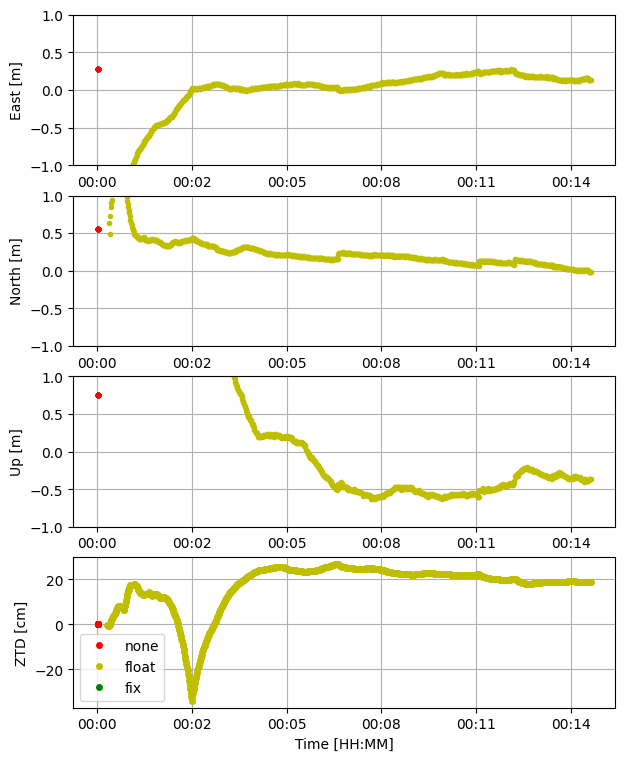

In [79]:
from cssrlib.plot import plot_enu

plot_enu(t, enu, smode, ztd)

## Example 7: PPP positioning (RTCM correction from JPL GDGPS)

This section demonstrates PPP positioning using PPP via JPL GDGPS (GPSHAS) corrections with a Septentrio mosaic-X5 receiver.

In [80]:
import os
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
from sys import exit as sys_exit
from sys import stdout

from cssrlib.gnss import ecef2pos, ecef2enu, Nav, rSigRnx, sys2str
from cssrlib.gnss import time2gpst, time2doy, time2str, timediff, epoch2time
from cssrlib.cssrlib import sCSSRTYPE, sCType
from cssrlib.peph import atxdec, searchpcv
from cssrlib.rtcm import rtcm
from cssrlib.pppssr import pppos
from cssrlib.rinex import rnxdec


In [81]:
# Start epoch and number of epochs
ep = [2025, 8, 21, 7, 0, 0] # start epoch

time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))

let = chr(ord('a')+ep[3])
bdir = f'cssrlib-data/data/doy{ep[0]:04d}-{doy:03d}/'
navfile = bdir+f'{doy:03d}{let}_rnx.nav'
obsfile = bdir+f'{doy:03d}{let}_rnx.obs'
atxfile = bdir+'../antex/igs20.atx'

# Specify JPL GDGPS corrections file in RTCM format
file_rtcm = bdir+f'jpl{doy:03d}{let}.rtcm3'

cs_mask = 1 << sCType.CLOCK | 1 << sCType.ORBIT

# Set user reference position
xyz_ref = [-3962108.6836, 3381309.5672, 3668678.6720]
pos_ref = ecef2pos(xyz_ref)

# Define signals to be processed
sigs = [rSigRnx("GC1C"), rSigRnx("GC2W"),
        rSigRnx("GL1C"), rSigRnx("GL2W"),
        rSigRnx("GS1C"), rSigRnx("GS2W"),
        rSigRnx("EC1C"), rSigRnx("EC7Q"),
        rSigRnx("EL1C"), rSigRnx("EL7Q"),
        rSigRnx("ES1C"), rSigRnx("ES7Q")]


In [82]:
rnx = rnxdec()
rnx.setSignals(sigs)

nav = Nav()
nav.pmode = 0 # Positioning mode: 0:static, 1:kinematic

# Decode RINEX NAV data
nav = rnx.decode_nav(navfile, nav)

# Load PPP corrections
v = np.genfromtxt(file_sbas, dtype=dtype)

cs = rtcm()
cs.monlevel = 0
cs.cssrmode = sCSSRTYPE.RTCM3_SSR
cs.inet = 0
# mask phase-bias for JPL GDGPS
cs.mask_pbias = True

# Load ANTEX data for satellites and stations
atx = atxdec()
atx.readpcv(atxfile)

nav.monlevel = 0  # Logging level

if True:
    fc = open(file_rtcm, 'rb')
    if not fc:
        print("RTCM message file cannot open.")

    blen = os.path.getsize(file_rtcm)
    msg = fc.read(blen)
    maxlen = len(msg)-5
    fc.close()

# Load RINEX OBS file header
if rnx.decode_obsh(obsfile) >= 0:

    # Auto-substitute signals
    rnx.autoSubstituteSignals()

    # Initialize position
    rr = rnx.pos
    pos = ecef2pos(rr)
    ppp = pppos(nav, rnx.pos, 'test_ppprtcm.log')
    nav.elmin = np.deg2rad(5.0)
    
    # Set PCO/PCV information
    nav.sat_ant = atx.pcvs
    nav.rcv_ant = searchpcv(atx.pcvr, rnx.ant,  rnx.ts)

For signals, L1C/A+L2P(Y) for GPS, E1+E5b for Galileo are used.

In [83]:
print("Available signals")
for sys, sigs in rnx.sig_map.items():
  txt = "{:7s} {}".format(sys2str(sys),
        ' '.join([sig.str() for sig in sigs.values()]))
  print(txt)

print("\nSelected signals")
for sys, tmp in rnx.sig_tab.items():
  txt = "{:7s} ".format(sys2str(sys))
  for _, sigs in tmp.items():
    txt += "{} ".format(' '.join([sig.str() for sig in sigs]))
  print(txt)

Available signals
GPS     C1C L1C D1C S1C C2W L2W D2W S2W C2L L2L D2L S2L C5Q L5Q D5Q S5Q
GLONASS C1C L1C D1C S1C C2C L2C D2C S2C C2P L2P D2P S2P C3Q L3Q D3Q S3Q
GALILEO C1C L1C D1C S1C C5Q L5Q D5Q S5Q C7Q L7Q D7Q S7Q C8Q L8Q D8Q S8Q C6C L6C D6C S6C
BEIDOU  C1P L1P D1P S1P C2I L2I D2I S2I C5P L5P D5P S5P C6I L6I D6I S6I C7D L7D D7D S7D C7I L7I D7I S7I
QZSS    C1C L1C D1C S1C C1E L1E D1E S1E C1L L1L D1L S1L C2L L2L D2L S2L C5Q L5Q D5Q S5Q
IRNSS   C1P L1P D1P S1P C5A L5A D5A S5A

Selected signals
GPS     C1C C2W L1C L2W S1C S2W 
GALILEO C1C C7Q L1C L7Q S1C S7Q 


Process data for 15 minutes (ok to abort before finished)

In [84]:
nep = 15 * 60  # increase this to run longer

# Intialize data structures for results
t = np.zeros(nep)
enu = np.ones((nep, 3))*np.nan
sol = np.zeros((nep, 4))
ztd = np.zeros((nep, 1))
smode = np.zeros(nep, dtype=int)

# Skip epochs until start time
obs = rnx.decode_obs()
while time > obs.t and obs.t.time != 0:
    obs = rnx.decode_obs()

k = 0
# Loop over number of epoch from file start
for ne in range(nep):
    week, tow = time2gpst(obs.t)
    cs.week = week
    cs.tow0 = tow//3600*3600
    
    # Set initial epoch
    if ne == 0:
        nav.t = deepcopy(obs.t)
        t0 = deepcopy(obs.t)
        t0.time = t0.time//30*30
        nav.time_p = t0

    while True:
        stat = cs.sync(msg, k)
        if stat is False:
            k += 1
            continue
        if not cs.checksum(msg, k, maxlen):
            k += 1
            continue

        tc = cs.decode_time(msg[k:k+cs.len+3])
        if (tc is not False) and timediff(tc, obs.t) > 0:
            break

        _, _, eph, geph, seph = cs.decode(msg[k:k+cs.len+3])
        k += cs.dlen

        if cs.msgtype in cs.eph_t.values():
            nav.eph.append(eph)

    # Call PPP module
    if (cs.lc[0].cstat & cs_mask) == cs_mask:
        ppp.process(obs, cs=cs)

    # Save output
    t[ne] = timediff(nav.t, t0) / 86400.0
    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = ecef2enu(pos_ref, sol-xyz_ref)
    ztd[ne] = nav.xa[ppp.IT(nav.na)] if nav.smode == 4 else nav.x[ppp.IT(nav.na)]
    smode[ne] = nav.smode

    # Log to standard output
    stdout.write('\r {} ENU {:7.3f} {:7.3f} {:7.3f}, 2D {:6.3f}, mode {:1d}'
                 .format(time2str(obs.t),
                         enu[ne, 0], enu[ne, 1], enu[ne, 2],
                         np.sqrt(enu[ne, 0]**2+enu[ne, 1]**2),
                         smode[ne]))

    # Get new epoch, exit after last epoch
    obs = rnx.decode_obs()
    if obs.t.time == 0:
        break

 2025-08-21 07:15:00 ENU  -0.013   0.114  -0.323, 2D  0.115, mode 5

Plot result

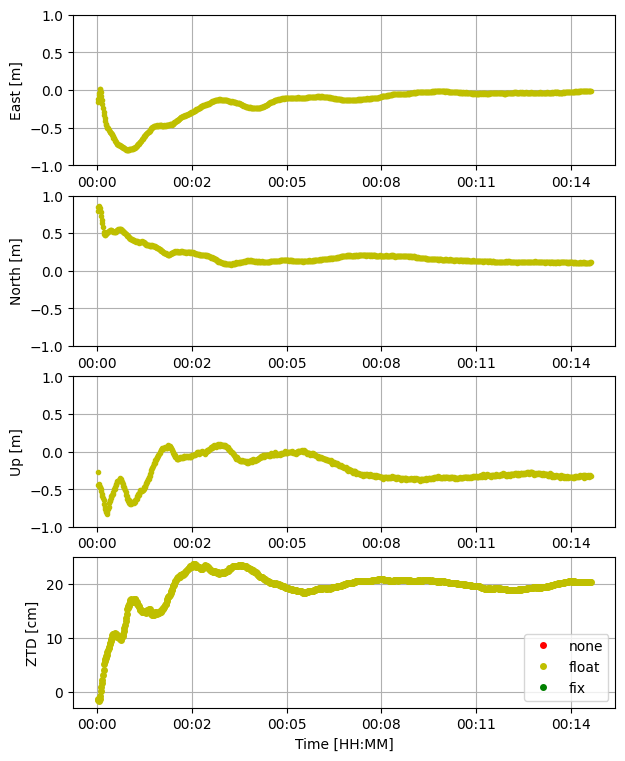

In [85]:
from cssrlib.plot import plot_enu

plot_enu(t, enu, smode, ztd)

## Reference

- [^1] T. Takasu, “RTKLIB: Open Source Program Package for RTK-GPS,” FOSS4G 2009 Tokyo, Japan, 2009.
- [^2] Hirokawa, R., Hauschild, A., Everett, T. (2023). Python Toolkit for Open PPP/PPP-RTK Services. In *Proceedings of the 35th International Technical Meeting of the Satellite Division of The Institute of Navigation (ION GNSS+ 2023)*
- [^3] Hirokawa, R., Hauschild, A. (2025). CSSRlib: Python Toolkit for High-Accuracy, Secure, and Resilient Positioning Services. In *Proceedings of the 37th International Technical Meeting of the Satellite Division of The Institute of Navigation (ION GNSS+ 2025)*